Code based on https://github.com/pytorch/examples/blob/master/mnist/main.py

In this exercise, we are going to implement a [UNet-like](https://arxiv.org/pdf/1505.04597.pdf) architecture for the semantic segmentation task.
The model is trained on the [CamVid](https://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) dataset.

Tasks:

    1. Implement the missing pieces in the code.
    2. Check that the given implementation reaches over 70% test accuracy after 10-15 epochs.
    3. Check how segmentations produced by the model compare to ground truth segementations.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from PIL import Image

In [2]:
class UNetConvolutionStack(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(UNetConvolutionStack, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


In [3]:
class EncoderStack(nn.Module):
    def __init__(self, in_channel, out_channel, first_layer=False):
        super(EncoderStack, self).__init__()
        if first_layer:
            self.down = nn.Sequential(
                UNetConvolutionStack(in_channel, out_channel),
                UNetConvolutionStack(out_channel, out_channel),
            )
        else:
            self.down = nn.Sequential(
                nn.MaxPool2d((2, 2)),
                UNetConvolutionStack(in_channel, out_channel),
                UNetConvolutionStack(out_channel, out_channel),
            )

    def forward(self, x):
        x = self.down(x)
        return x


In [4]:
class DecoderStack(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(DecoderStack, self).__init__()
        self.upsample = nn.ConvTranspose2d(
            in_channel, in_channel, 3, stride=2, padding=1
        )
        self.up = nn.Sequential(
            UNetConvolutionStack(in_channel + out_channel, out_channel),
            UNetConvolutionStack(out_channel, out_channel),
        )

    def forward(self, x, y):
        # TODO: implement skip connections.
        # hint: x is the output of previous decoder layer,
        # y is the output of corresponding encoder layer.
        # Based on the arguments of the constructor,
        # how should x and y be combined?
        x = self.upsample(x, output_size=y.size())
        x = torch.cat([y,x], dim=1)
        x = self.up(x)
        return x

In [13]:
class UNet(nn.Module):
    def __init__(self, encoder_channels, decoder_channels, num_classes):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.conv = nn.Conv2d(
            decoder_channels[-1], num_classes, kernel_size=3, padding=1
        )

        encoder_sizes = zip(
            range(len(encoder_channels)), encoder_channels, encoder_channels[1:]
        )
        for idx, in_size, out_size in encoder_sizes:
            if idx > 0:
                self.encoder.append(EncoderStack(in_size, out_size))
            else:
                self.encoder.append(EncoderStack(in_size, out_size, first_layer=True))

        decoder_sizes = zip(decoder_channels, decoder_channels[1:])
        for in_size, out_size in decoder_sizes:
            self.decoder.append(DecoderStack(in_size, out_size))

    def forward(self, x):
        # TODO: implement UNet's forward pass.
        # hint: Remember to store outputs of subsequent
        # encoder layers to use as input to decoder layers!
        # Do not forget about the final convolution.
        encoder_outputs = []

        for l in self.encoder:
            x = l(x)
            encoder_outputs.append(x)

        del encoder_outputs[-1]

        for y, l in zip(list(reversed(encoder_outputs)), self.decoder):
            x = l(x, y)

        x = self.conv(x)
        return x

In [6]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        log_probs = F.log_softmax(output, dim=1)
        loss = F.nll_loss(log_probs, target)
        pred = log_probs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            _, _, image_width, image_height = data.size()
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
    print(
        "Train accuracy: {}/{} ({:.0f}%)".format(
            correct,
            (len(train_loader.dataset) * image_width * image_height),
            100.0 * correct / (len(train_loader.dataset) * image_width * image_height),
        )
    )


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            log_probs = F.log_softmax(output, dim=1)
            test_loss += F.nll_loss(
                log_probs, target, reduction="sum",
            ).item()  # sum up batch loss
            pred = log_probs.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    _, _, image_width, image_height = data.size()
    test_loss /= len(test_loader.dataset) * image_width * image_height

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            (len(test_loader.dataset) * image_width * image_height),
            100.0 * correct / (len(test_loader.dataset) * image_width * image_height),
        )
    )


In [7]:
batch_size = 50
test_batch_size = 1000
epochs = 15
lr = 2e-3
use_cuda = True
seed = 1
log_interval = 10
test_size = 80
data_root = '../data'

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
num_classes = 32


In [8]:
use_cuda = use_cuda and torch.cuda.is_available()

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {"batch_size": batch_size}
test_kwargs = {"batch_size": test_batch_size}
if use_cuda:
    cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)


In [9]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, filenames, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.filenames = filenames
        self.transform = transform
        self.target_transform = target_transform
        self.transformed_data_dir = os.path.join(root_dir, 'transformed')
        if not os.path.exists(self.transformed_data_dir):
            os.mkdir(self.transformed_data_dir)
            os.mkdir(os.path.join(self.transformed_data_dir, 'images'))
            os.mkdir(os.path.join(self.transformed_data_dir, 'labels'))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]

        transformed_image_path = os.path.join(self.transformed_data_dir, 'images', filename)
        transformed_target_path = os.path.join(self.transformed_data_dir, 'labels', filename)
        if os.path.exists(transformed_image_path) and os.path.exists(transformed_target_path):
            img = torch.load(transformed_image_path)
            target = torch.load(transformed_target_path)
        else:
            image_path = os.path.join(self.root_dir, '701_StillsRaw_full', f'{filename}.png')
            target_path = os.path.join(self.root_dir, 'labels', f'{filename}_L.png')

            img = Image.open(image_path).convert('RGB')
            target = Image.open(target_path)

            if self.transform is not None:
                img = self.transform(img)
            if self.target_transform is not None:
                target = self.target_transform(target)
            # Applying transformations takes a long. So we do this only once,
            # then save transformed tensors to files and read them when they are needed again.
            # This significantly speeds up next iterations over dataset.
            torch.save(img, transformed_image_path)
            torch.save(target, transformed_target_path)

        return img, target

In [10]:
# Download dataset
!mkdir -p {data_root}
!wget -c -P {data_root} https://datasets.cms.waikato.ac.nz/ufdl/data/camvid/701_StillsRaw_full.zip
!wget -c -P {data_root} https://datasets.cms.waikato.ac.nz/ufdl/data/camvid/LabeledApproved_full.zip
!wget -c -P {data_root} https://datasets.cms.waikato.ac.nz/ufdl/data/camvid/label_colors.txt
!if [[ ! -d {data_root}/701_StillsRaw_full ]]; then unzip {data_root}/701_StillsRaw_full.zip -d {data_root}; fi
!if [[ ! -d {data_root}/labels ]]; then unzip {data_root}/LabeledApproved_full.zip -d {data_root}/labels; fi
!rm {data_root}/701_StillsRaw_full/Seq05VD_f02610.png 2>/dev/null
!rm {data_root}/labels/Seq05VD_f02610_L.png 2>/dev/null

--2024-09-02 16:04:38--  https://datasets.cms.waikato.ac.nz/ufdl/data/camvid/701_StillsRaw_full.zip
Resolving datasets.cms.waikato.ac.nz (datasets.cms.waikato.ac.nz)... 192.107.172.70
Connecting to datasets.cms.waikato.ac.nz (datasets.cms.waikato.ac.nz)|192.107.172.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 584553911 (557M) [application/zip]
Saving to: ‘../data/701_StillsRaw_full.zip’

701_StillsRaw_full. 100%[===================>] 557.47M  3.95MB/s    in 98s     

2024-09-02 16:06:16 (5.71 MB/s) - ‘../data/701_StillsRaw_full.zip’ saved [584553911/584553911]

--2024-09-02 16:06:17--  https://datasets.cms.waikato.ac.nz/ufdl/data/camvid/LabeledApproved_full.zip
Resolving datasets.cms.waikato.ac.nz (datasets.cms.waikato.ac.nz)... 192.107.172.70
Connecting to datasets.cms.waikato.ac.nz (datasets.cms.waikato.ac.nz)|192.107.172.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16567585 (16M) [application/zip]
Saving to: ‘../data/La

In [11]:
labels_colors = open(os.path.join(data_root, 'label_colors.txt'), 'r').readlines()
labels_colors = [torch.tensor(list(map(int, line.split()[:3]))) for line in labels_colors]
filenames = [fname[:-4] for fname in os.listdir(os.path.join(data_root, '701_StillsRaw_full'))]
filenames_train = filenames[:-test_size]
filenames_test = filenames[-test_size:]

def rgb_to_single_color(x):
    ret = torch.zeros(x.shape[1], x.shape[2], dtype=torch.long)
    for single_color, rgb_colors in enumerate(labels_colors):
        rgb_colors = rgb_colors.unsqueeze(1).unsqueeze(2)
        indices = torch.all(torch.eq(x, rgb_colors), dim=0)
        ret[indices] = single_color
    return ret


input_resize = transforms.Resize((240, 320))
input_transform = transforms.Compose(
    [
        input_resize,
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

target_resize = transforms.Resize((240, 320), interpolation=InterpolationMode.NEAREST)
target_transform = transforms.Compose(
    [
        target_resize,
        transforms.PILToTensor(),
        transforms.Lambda(rgb_to_single_color),
    ]
)

train_dataset = SegmentationDataset(
    data_root,
    filenames_train,
    transform=input_transform,
    target_transform=target_transform,
)
test_dataset = SegmentationDataset(
    data_root,
    filenames_test,
    transform=input_transform,
    target_transform=target_transform,
)

train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **train_kwargs)

In [14]:
model = UNet(
    encoder_channels=[3, 8, 16, 32],
    decoder_channels=[32, 16, 8],
    num_classes=num_classes,
).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)


<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Train Epoch: 1 [0/620 (0%)]	Loss: 3.621905
Train Epoch: 1 [500/620 (77%)]	Loss: 2.603828
Train accuracy: 11429841/47616000 (24%)
Test set: Average loss: 2.8162, Accuracy: 1733290/6144000 (28%)



<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Train Epoch: 2 [0/620 (0%)]	Loss: 2.312038
Train Epoch: 2 [500/620 (77%)]	Loss: 1.821909
Train accuracy: 23112480/47616000 (49%)


<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Test set: Average loss: 1.9386, Accuracy: 2846598/6144000 (46%)



<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Train Epoch: 3 [0/620 (0%)]	Loss: 1.721424
Train Epoch: 3 [500/620 (77%)]	Loss: 1.459120
Train accuracy: 25127229/47616000 (53%)


<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Test set: Average loss: 1.8138, Accuracy: 3304391/6144000 (54%)



<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Train Epoch: 4 [0/620 (0%)]	Loss: 1.413991
Train Epoch: 4 [500/620 (77%)]	Loss: 1.293075
Train accuracy: 29196414/47616000 (61%)


<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Test set: Average loss: 1.4314, Accuracy: 3665942/6144000 (60%)



<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Train Epoch: 5 [0/620 (0%)]	Loss: 1.256582
Train Epoch: 5 [500/620 (77%)]	Loss: 1.229526
Train accuracy: 29972094/47616000 (63%)


<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Test set: Average loss: 1.2255, Accuracy: 3862394/6144000 (63%)



<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Train Epoch: 6 [0/620 (0%)]	Loss: 1.178797
Train Epoch: 6 [500/620 (77%)]	Loss: 1.133816
Train accuracy: 31680031/47616000 (67%)


<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Test set: Average loss: 1.1437, Accuracy: 4114092/6144000 (67%)



<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Train Epoch: 7 [0/620 (0%)]	Loss: 1.061970
Train Epoch: 7 [500/620 (77%)]	Loss: 1.072145
Train accuracy: 32835148/47616000 (69%)


<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Test set: Average loss: 1.1278, Accuracy: 4159243/6144000 (68%)



<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Train Epoch: 8 [0/620 (0%)]	Loss: 1.048823
Train Epoch: 8 [500/620 (77%)]	Loss: 1.026124
Train accuracy: 33588979/47616000 (71%)


<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Test set: Average loss: 1.0085, Accuracy: 4344611/6144000 (71%)



<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Train Epoch: 9 [0/620 (0%)]	Loss: 1.009216
Train Epoch: 9 [500/620 (77%)]	Loss: 0.974367
Train accuracy: 34278349/47616000 (72%)


<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Test set: Average loss: 0.9858, Accuracy: 4411824/6144000 (72%)



<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Train Epoch: 10 [0/620 (0%)]	Loss: 1.007887
Train Epoch: 10 [500/620 (77%)]	Loss: 0.922271
Train accuracy: 34872409/47616000 (73%)


<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Test set: Average loss: 1.0035, Accuracy: 4471985/6144000 (73%)



<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Train Epoch: 11 [0/620 (0%)]	Loss: 0.923153
Train Epoch: 11 [500/620 (77%)]	Loss: 0.976965
Train accuracy: 35199216/47616000 (74%)


<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Test set: Average loss: 0.9806, Accuracy: 4425145/6144000 (72%)



<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Train Epoch: 12 [0/620 (0%)]	Loss: 0.927613
Train Epoch: 12 [500/620 (77%)]	Loss: 0.902506
Train accuracy: 35342177/47616000 (74%)


<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Test set: Average loss: 0.9025, Accuracy: 4595857/6144000 (75%)



<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Train Epoch: 13 [0/620 (0%)]	Loss: 0.911630
Train Epoch: 13 [500/620 (77%)]	Loss: 0.938445
Train accuracy: 35608382/47616000 (75%)


<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Test set: Average loss: 1.0003, Accuracy: 4483121/6144000 (73%)



<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Train Epoch: 14 [0/620 (0%)]	Loss: 0.786205
Train Epoch: 14 [500/620 (77%)]	Loss: 0.861331
Train accuracy: 36007199/47616000 (76%)


<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Test set: Average loss: 0.9126, Accuracy: 4574626/6144000 (74%)



<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Train Epoch: 15 [0/620 (0%)]	Loss: 0.783106
Train Epoch: 15 [500/620 (77%)]	Loss: 0.814004
Train accuracy: 36368468/47616000 (76%)


<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

Test set: Average loss: 0.8457, Accuracy: 4691414/6144000 (76%)



<ipython-input-9-dad8e1b5fb1a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(transformed_image_path)
<ipython-input-9-dad8e1b5fb1a>:23: FutureWarning: Y

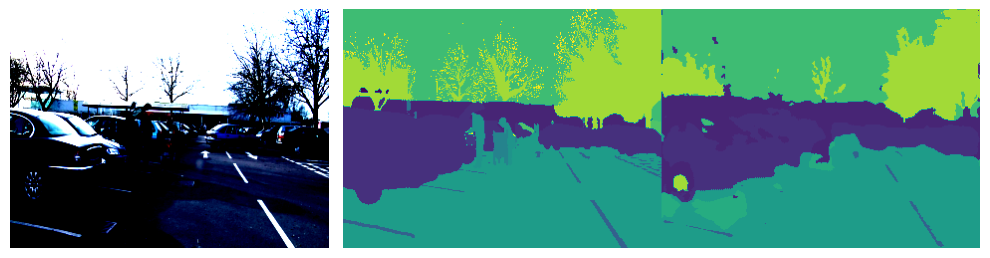

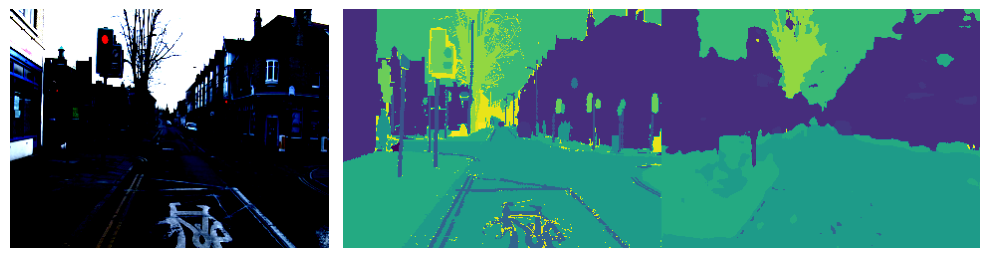

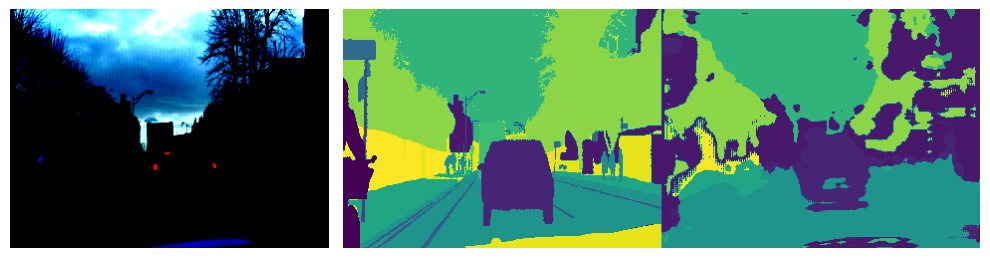

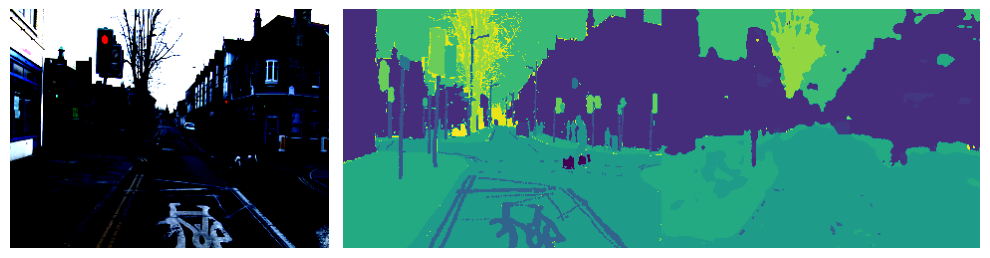

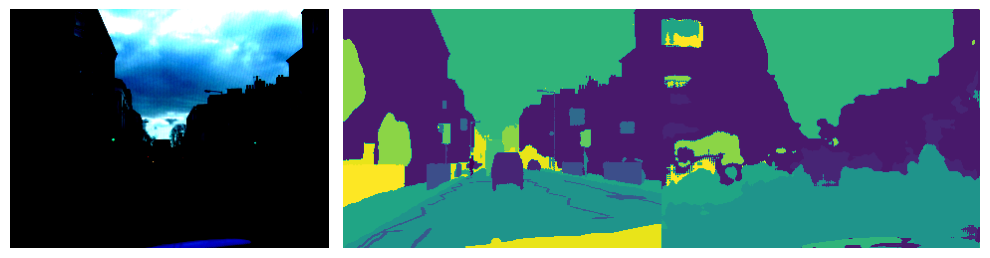

In [15]:
data, target = next(iter(test_loader))
output = model(data.to(device))
pred = output.argmax(dim=1, keepdim=True).to('cpu')

for i in range(5):
    image = data[i].permute(1, 2, 0).numpy()
    target_segmentation = target[i]
    pred_segmentation = pred[i].squeeze()

    fig, axes = plt.subplots(1, 2, figsize=(10, 20), gridspec_kw={'width_ratios': [1, 2]})
    segmentations = torch.hstack([target_segmentation, pred_segmentation])
    segmentations = segmentations.unsqueeze(2).numpy()
    axes[0].imshow(np.clip(image, 0, 1))
    axes[0].axis('off')
    axes[1].imshow(segmentations)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()